# Experimenting with Package Functions

IN PROGRESS

## Initial simulated LC generation with MOSFIT

In [2]:
from survey_agnostic_sn_vae.data_generation.mosfit2 import *
# from ..survey_agnostic_sn_vae.data_generation.objects import *
import os
OUTPUT_PATH = os.getcwd()
print(OUTPUT_PATH)
os.makedirs(OUTPUT_PATH+"/transients", exist_ok=True)

#print(OUTPUT_PATH)
#for f in glob.glob(OUTPUT_PATH+"/transients/*"):
#    os.remove(f) 

gen_single_core(0)


/Users/kdesoto/python_repos/survey-agnostic-sn-vae/data
Switching to MOSFIT path: /Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/mosfit
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/tw/lcx0pdpj1154k09tffj5_3440000gn/T/ipykernel_8813/3721148413.py", line 12, in <module>
    gen_single_core(0)
  File "/Users/kdesoto/python_repos/survey-agnostic-sn-vae/src/survey_agnostic_sn_vae/data_generation/mosfit2.py", line 26, in gen_single_core
    lsst_survey = Survey(
                  ^^^^^^^
  File "/Users/kdesoto/python_repos/survey-agnostic-sn-vae/src/survey_agnostic_sn_vae/data_generation/objects.py", line 104, in __init__
    self.fitter.fit_events(
  File "/Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/mosfit/fitter.py", line 226, in fit_events
    self._converter = Converter(prt, require_source=upload, guess=guess,
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users

In [ ]:
from survey_agnostic_sn_vae.data_generation.objects import *

OUTPUT_PATH = os.getcwd()

# Now, load Transient object
all_transient_fns = glob.glob(OUTPUT_PATH+"/transients/*")
test_transient = Transient.load(
    all_transient_fns[0],
)
print(test_transient.lightcurves) # should be 2
for lc in test_transient.lightcurves:
    print(lc.bands)
    print(lc.survey.bands)

Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
[<survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x106073880>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x15798f250>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x1749f0160>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x303416320>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x303415030>]
['g' 'i' 'r' 'u' 'y

## Prune simulated SNe and quality check

In [ ]:
# convert to SNAPI Transient objects
import os, glob
from survey_agnostic_sn_vae.data_generation.convert_to_snapi import convert_transient_to_snapi

save_dir = 'snapi_transients_simulated'
os.makedirs(save_dir, exist_ok=True)

for i, transient_fn in enumerate(glob.glob("transients/*.pickle")):
    if i % 1000 == 0:
        print(f"Processed {i} transients...")
    convert_transient_to_snapi(transient_fn, save_dir)

Processed 0 transients...
Processed 1000 transients...
Processed 2000 transients...
Processed 3000 transients...


In [ ]:
# check dataset size
import os

_, _, files = next(os.walk("snapi_transients_simulated"))
file_count = len(files)
print(f"Simulated dataset: {file_count} files")

Simulated dataset: 1218 files


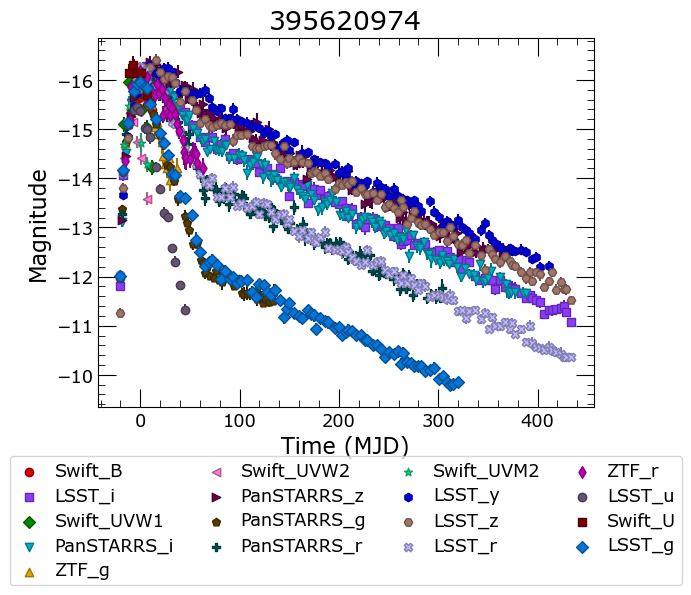

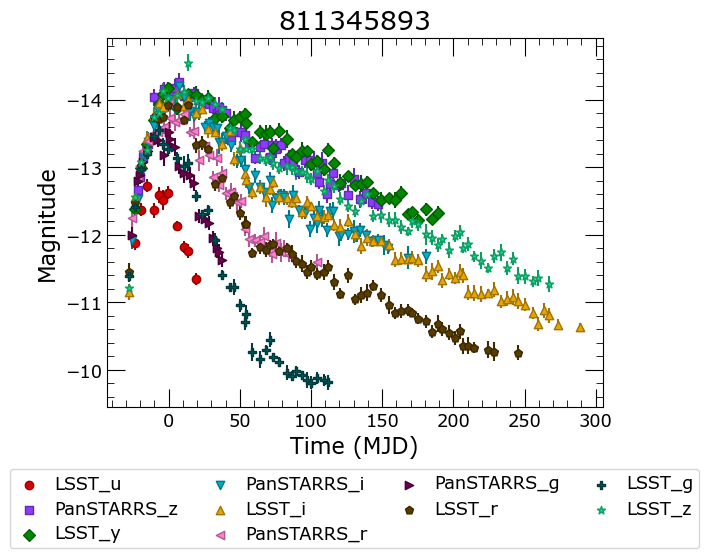

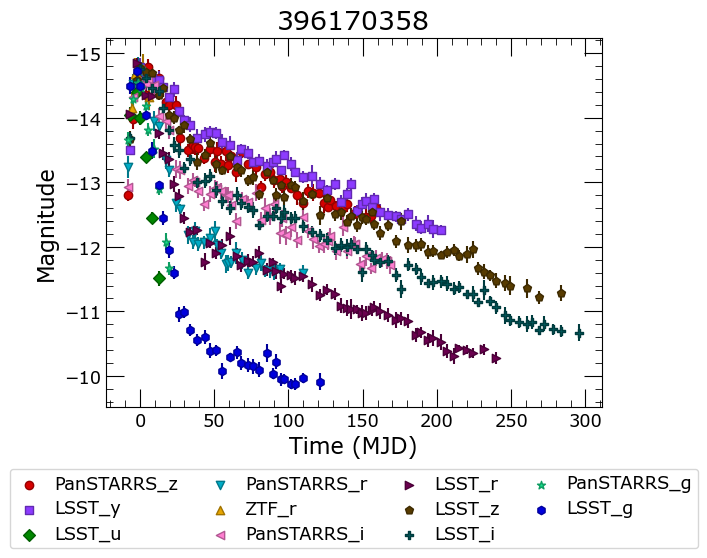

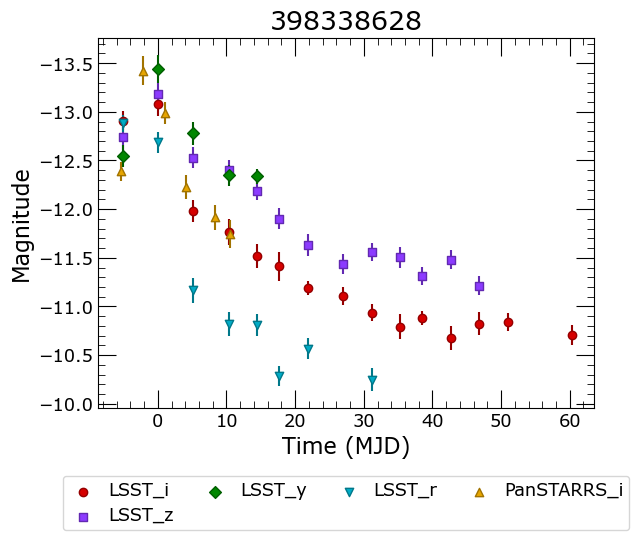

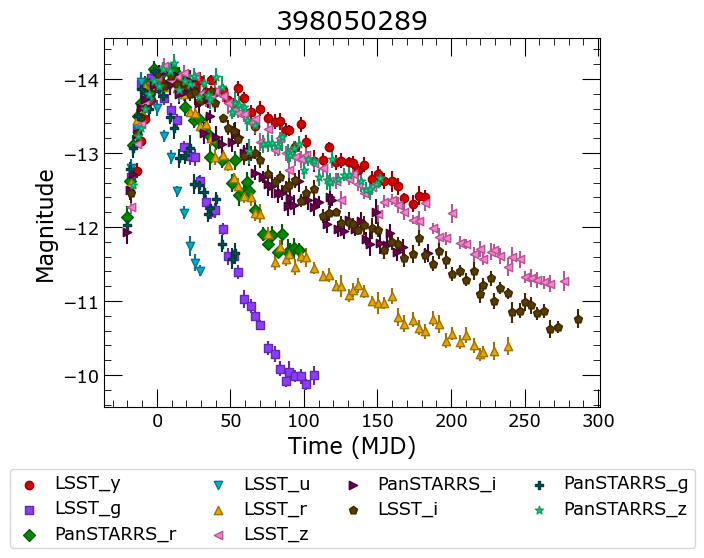

In [ ]:
# check LC quality
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

formatter = Formatter()
for fn in glob.glob("snapi_transients_simulated/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    plt.title(transient.id)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

## Data Augmentation
Here we randomly augment the LCs via sub-sampling and only including certain regions.

In [ ]:
import glob
import os
import numpy as np
from snapi import Transient, Photometry
rng = np.random.default_rng()

save_dir = "snapi_transients_augmented"
os.makedirs(save_dir, exist_ok=True)
all_fns = glob.glob("snapi_transients_simulated/*.hdf5")

for i, fn in enumerate(all_fns):
    if i % 100 == 0:
        print(f"Augmented {i} out of {len(all_fns)} transients...")
    transient = Transient.load(fn)
    
    aug_set1 = set()
    aug_set2 = set()
    aug_set3 = set()

    rand_mint = rng.uniform(low=np.min(transient.photometry.times), high=np.max(transient.photometry.times))
    rand_maxt = rng.uniform(low=rand_mint, high=np.max(transient.photometry.times))

    # add phase wiggles of sigma = 3 days (to account for cadence)
    phase_wiggles = rng.normal(loc=0., scale=3., size=3)

    for lc in transient.photometry.light_curves:
        # first, resample 3 times
        resampled_mags = lc.resample(mags=True, num=3)

        # augment 1: just resample at existing times
        aug = lc.copy()
        aug.mags = resampled_mags[0]
        aug_set1.add(aug)

        # augment 2: resample, then subsample LC
        aug1 = lc.copy()
        aug1.mags = resampled_mags[1]
        if len(aug1.times) > 5:
            subsample_num = rng.integers(low=5, high=min(len(aug1.times), 32))
            aug1.subsample(subsample_num)
        aug_set2.add(aug1)

        # augment 3: resample, truncate, then subsample
        aug2 = lc.copy()
        aug2.mags = resampled_mags[2]
        aug2.truncate(max_t=rand_maxt, min_t=rand_mint)
        if len(aug2.times) < 5:
            continue
        if len(aug2.times) > 5:
            subsample_num2 = rng.integers(low=5, high=min(len(aug2.times), 32))
            aug2.subsample(subsample_num2)
        aug_set3.add(aug2)


    for i, aug_lcs in enumerate([transient.photometry.light_curves, aug_set1, aug_set2, aug_set3]):
        if len(aug_lcs) < 2:
            continue
        augmented_photometry = Photometry(aug_lcs)
        augmented_photometry.phase() # re-phase
        if i > 0:
            augmented_photometry.phase(phase_wiggles[i-1]) # phase wiggle
        transient.photometry = augmented_photometry
        transient.save(
            os.path.join(save_dir, f"{transient.id}_{i}.hdf5")
        )


Augmented 0 out of 1217 transients...
Augmented 100 out of 1217 transients...
Augmented 200 out of 1217 transients...
Augmented 300 out of 1217 transients...
Augmented 400 out of 1217 transients...
Augmented 500 out of 1217 transients...
Augmented 600 out of 1217 transients...
Augmented 700 out of 1217 transients...
Augmented 800 out of 1217 transients...
Augmented 900 out of 1217 transients...
Augmented 1000 out of 1217 transients...
Augmented 1100 out of 1217 transients...
Augmented 1200 out of 1217 transients...


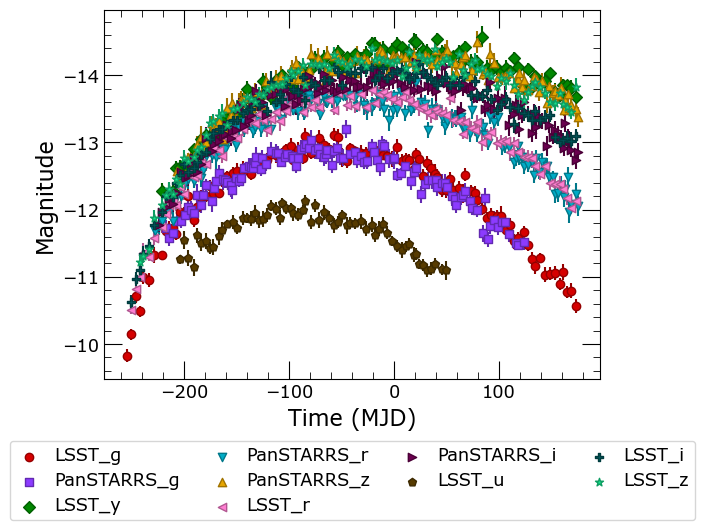

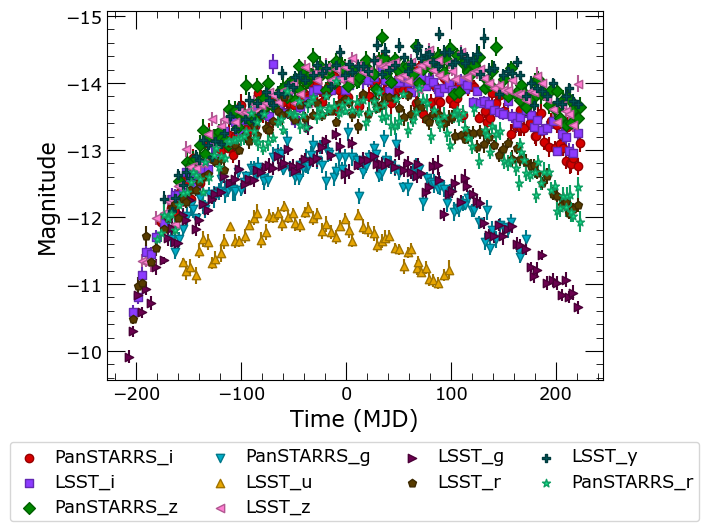

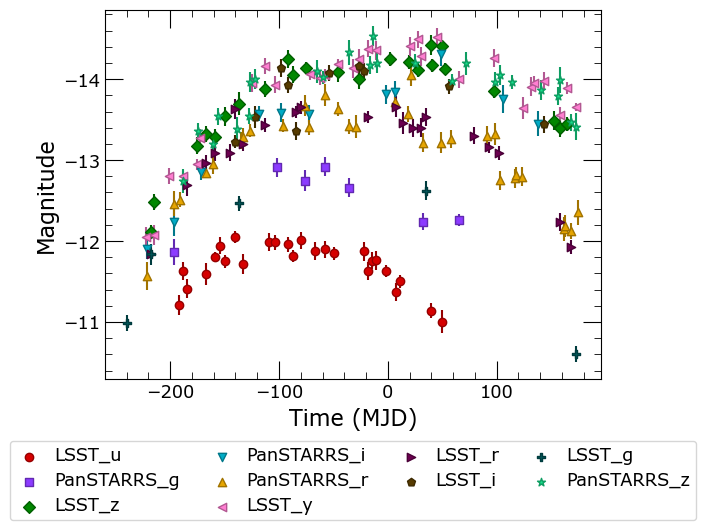

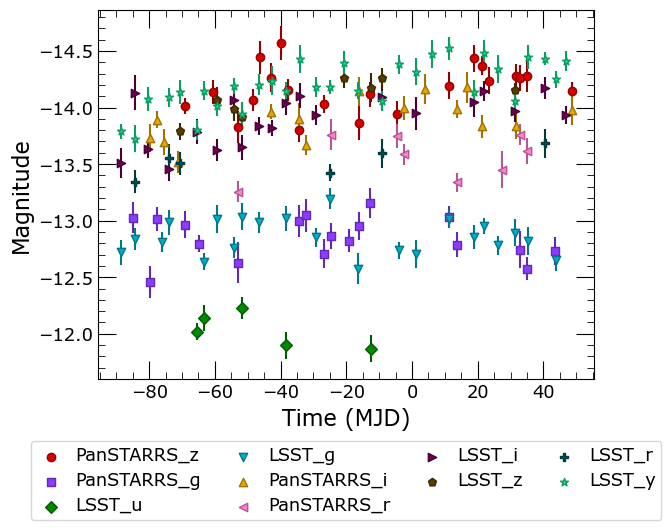

In [ ]:
# check augmentations for a LC
# check LC quality
from snapi import Formatter, Transient
import matplotlib.pyplot as plt

formatter = Formatter()
for i in range(4):
    fn = f"snapi_transients_augmented/811344797_{i}.hdf5"
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

## Sanity check Pre-processing
During pre-processing, we create a 3d array containing the dense arrays of each light curve. We ensure that each light curve is tiled to 6 bands (where we repeat when necessary) to have uniformly-sized arrays.

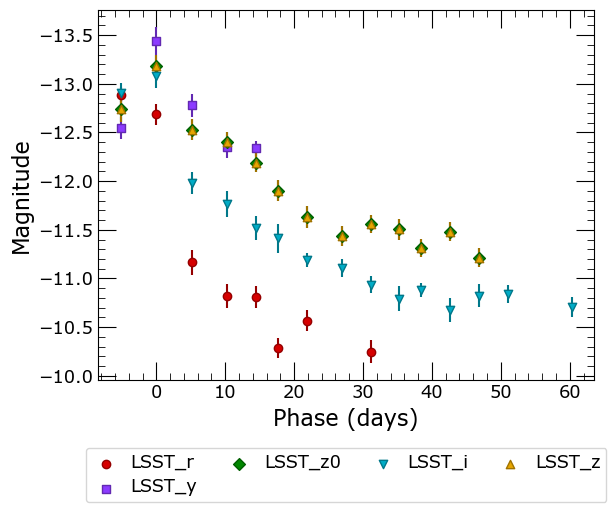

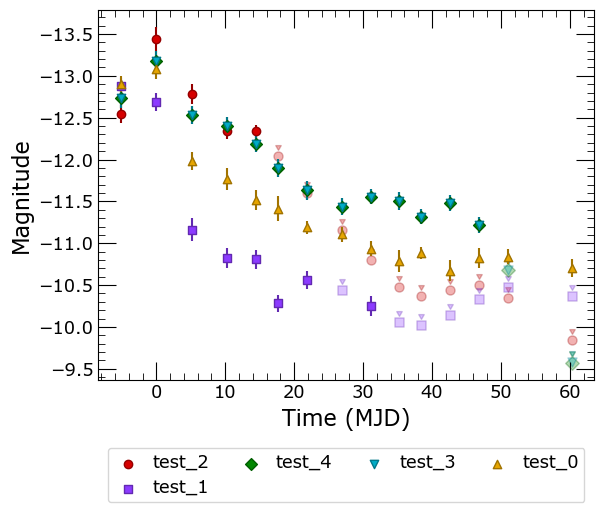

In [ ]:
import os
import shutil
from survey_agnostic_sn_vae.preprocessing import prep_input
from snapi import Photometry, LightCurve, Filter, Transient, Formatter
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

formatter = Formatter()

orig_transient = Transient.load("test_data/398338628_0.hdf5")
orig_photometry = orig_transient.photometry
orig_photometry.tile(6)
orig_photometry.phase()
for lc in orig_photometry.light_curves:
    if str(lc.filter)[-1] == '0':
        repeat_instrument = lc.filter.instrument
        break
photometry = orig_photometry.filter_by_instrument(repeat_instrument)
dense_arr = photometry.dense_array()

#original
fig, ax = plt.subplots()
photometry.plot(ax=ax, formatter=formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax)
plt.show()

# recreated
nfilts = len(photometry)
times = dense_arr[:,0]
dense_mags = dense_arr[:,1:1+nfilts]
dense_mag_errs = dense_arr[:,1+nfilts:1+2*nfilts]
interpolated_mask = dense_arr[:,1+2*nfilts:1+3*nfilts]

rec_lcs = set()
for i in range(len(photometry)):
    recreation = LightCurve(
        times=Time(times, format='mjd'),
        mags=dense_mags[:,i],
        mag_errs=dense_mag_errs[:,i],
        upper_limits=interpolated_mask[:,i].astype(bool),
        filt = Filter(
            instrument="test",
            band=str(i),
            center=np.nan * u.AA
        )
    )
    rec_lcs.add(recreation)

formatter.reset_colors()
formatter.reset_markers()

fig, ax = plt.subplots()
photometry = Photometry(rec_lcs)
photometry.plot(ax=ax, formatter=formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax)
plt.show()


Pre-processed 0 out of 3 transients...
0.009408946476548326 3.263858342691151
{'ids': array(['398338628', '811344797', '811495301'], dtype='<U9'), 'classes': array([None, None, None], dtype=object)}


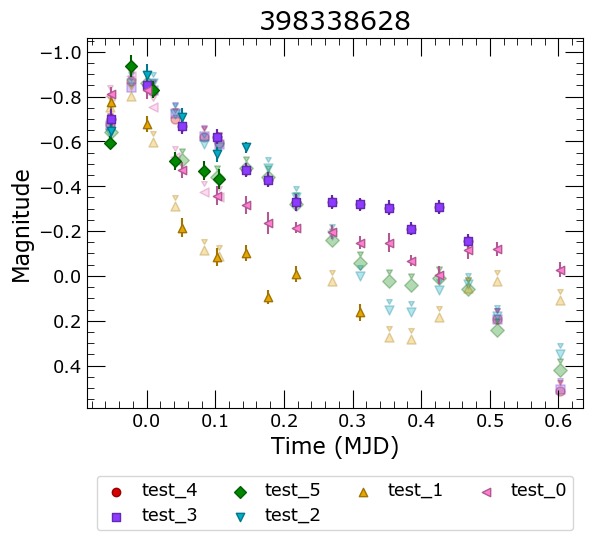

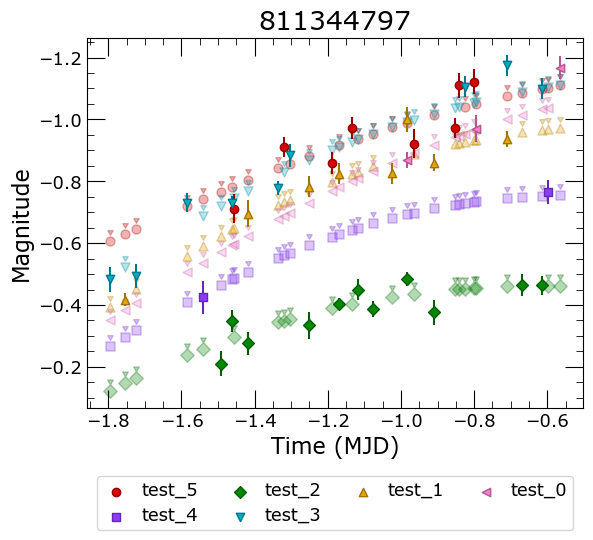

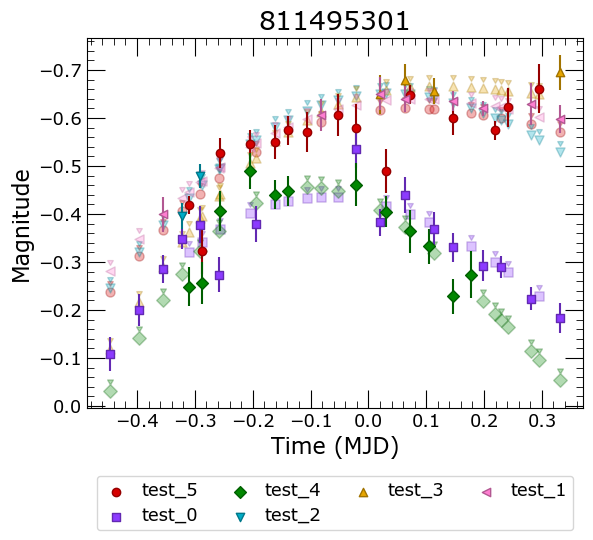

In [ ]:
# now check prep_input function
import os
import shutil
from snapi import Formatter, LightCurve, Photometry, Filter
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from survey_agnostic_sn_vae.preprocessing import prep_input

test_dir = "test_data"
shutil.rmtree(test_dir)
os.makedirs(test_dir, exist_ok=True)
shutil.copyfile("snapi_transients_augmented/398338628_1.hdf5", "test_data/398338628_1.hdf5")
shutil.copyfile("snapi_transients_augmented/811495301_2.hdf5", "test_data/811495301_2.hdf5")
shutil.copyfile("snapi_transients_augmented/811344797_2.hdf5", "test_data/811344797_2.hdf5")
dense_arr, meta_dict = prep_input(test_dir, save=True, outdir='.')
print(meta_dict)

for j in range(3):
    nfilts = 6
    times = dense_arr[j,:,0]
    dense_mags = dense_arr[j,:,1:1+nfilts]
    dense_mag_errs = dense_arr[j,:,1+nfilts:1+2*nfilts]
    interpolated_mask = dense_arr[j,:,1+2*nfilts:1+3*nfilts]

    rec_lcs = set()
    for i in range(nfilts):
        recreation = LightCurve(
            times=Time(times[times < 10.], format='mjd'),
            mags=-1*dense_mags[times < 10.,i],
            mag_errs=dense_mag_errs[times < 10.,i],
            upper_limits=interpolated_mask[times < 10.,i].astype(bool),
            filt = Filter(
                instrument="test",
                band=str(i),
                center=np.nan * u.AA
            )
        )
        rec_lcs.add(recreation)

    formatter = Formatter()

    fig, ax = plt.subplots()
    photometry = Photometry(rec_lcs)
    photometry.plot(ax=ax, formatter=formatter)
    ax.set_title(meta_dict['ids'][j])
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
plt.show()




In [ ]:
# now create full preprocessed file - save to HDF5
import warnings

warnings.filterwarnings("ignore")

from survey_agnostic_sn_vae.preprocessing import prep_input

dense_arr, meta_dict = prep_input(
    "snapi_transients_augmented",
    save=True,
    save_fn='preprocessed_augmented.h5'
)

Pre-processed 0 out of 4622 transients...
Pre-processed 50 out of 4622 transients...
Pre-processed 100 out of 4622 transients...
Pre-processed 150 out of 4622 transients...
Pre-processed 200 out of 4622 transients...
Pre-processed 250 out of 4622 transients...
Pre-processed 300 out of 4622 transients...
Pre-processed 350 out of 4622 transients...
Pre-processed 400 out of 4622 transients...
Pre-processed 450 out of 4622 transients...
Pre-processed 500 out of 4622 transients...
Pre-processed 550 out of 4622 transients...
Pre-processed 600 out of 4622 transients...
Pre-processed 650 out of 4622 transients...
Pre-processed 700 out of 4622 transients...
Pre-processed 750 out of 4622 transients...
Pre-processed 800 out of 4622 transients...
Pre-processed 850 out of 4622 transients...
Pre-processed 900 out of 4622 transients...
Pre-processed 950 out of 4622 transients...
Pre-processed 1000 out of 4622 transients...
Pre-processed 1050 out of 4622 transients...
Pre-processed 1100 out of 4622 tr

## Train RAENN

Here, we use the Equinox package, which is a neural network library built on JAX.

 (1) First try just VAE encodings without similarity loss

In [ ]:
%env ENABLE_PJRT_COMPATIBILITY=1
from survey_agnostic_sn_vae.autoencoder.raenn_equinox import VAE, fit_model
import h5py
import time
import equinox as eqx

import jax

device = 'cpu'
jax.config.update('jax_platform_name', device)

# load data
with h5py.File('preprocessed_augmented.h5', 'r') as file:
    encoder_inputs = file['encoder_input'][:]
    ids = file['ids'][:]
    num_samples = len(encoder_inputs)
    train_encoder_inputs = encoder_inputs[:num_samples // 10 * 9]
    val_encoder_inputs = encoder_inputs[num_samples // 10 * 9:]
    train_ids = ids[:num_samples // 10 * 9]
    val_ids = ids[num_samples // 10 * 9:]

config = {
    "hidden_dim": 16,
    "out_dim": 4
}
# new model
#model = VAE(**config)
model_fn = "test_model_kl.eqx"

# load model
model = eqx.filter_eval_shape(VAE, **config)
model = eqx.tree_deserialise_leaves(model_fn, model)

start_time = time.time()
trained_model, loss, val_loss = fit_model(
    model=model,
    encoder_inputs=train_encoder_inputs,
    ids=train_ids,
    val_encoder_inputs=val_encoder_inputs,
    val_ids=val_ids,
    num_epochs=250,
    batch_size=128,
    learning_rate=1e-4,
    include_kl=True,
    contrastive_params="mahalonobis_1"
)

print("LOSSES", loss)
print("ELAPSED TIME", time.time() - start_time)
eqx.tree_serialise_leaves("test_model_mahalonobis_1.eqx", trained_model)

env: ENABLE_PJRT_COMPATIBILITY=1


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725386636.611994   54472 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725386636.621590   54472 service.cc:145] XLA service 0x16988b820 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725386636.621603   54472 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725386636.622893   54472 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725386636.622901   54472 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(926, 32, 31)
(8316, 32, 31)
(128, 4)
(926, 4)
Epoch 0: Training Log Loss=0.925, Validation Log Loss=1.198
Epoch 1: Training Log Loss=0.959, Validation Log Loss=1.218
Epoch 2: Training Log Loss=0.927, Validation Log Loss=1.188


KeyboardInterrupt: 

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725483809.740302  789406 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725483809.753475  789406 service.cc:145] XLA service 0x16c0cb910 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725483809.753486  789406 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725483809.755648  789406 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725483809.755667  789406 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(5, 1600, 31)
(5, 32, 31)
(512, 32, 31)
(512, 32, 31)


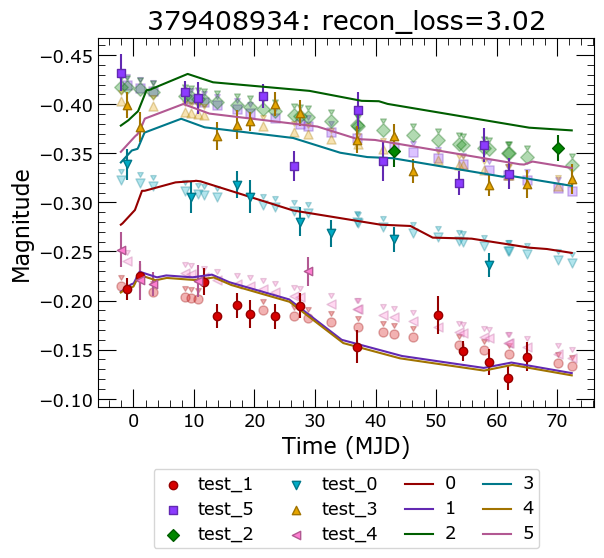

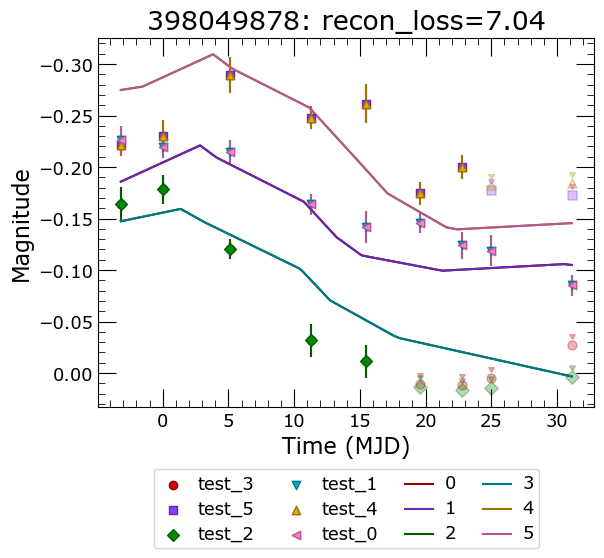

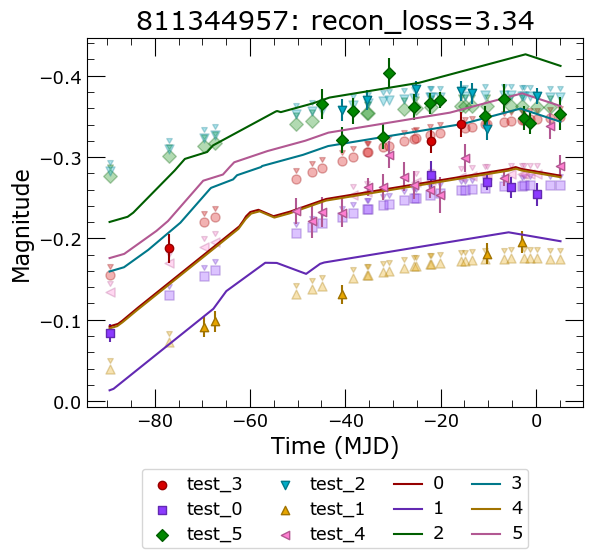

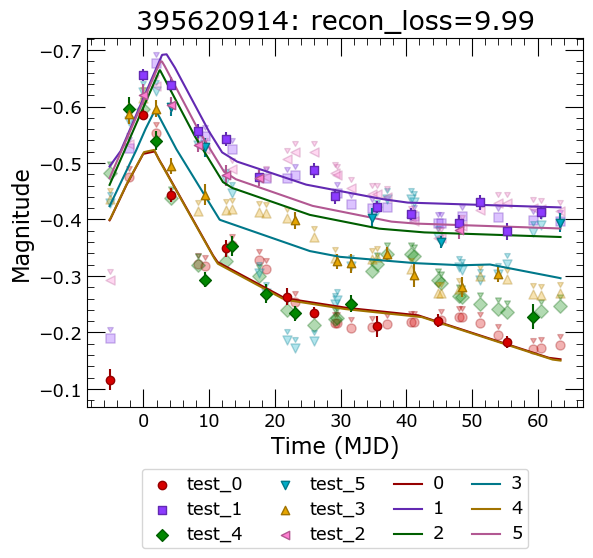

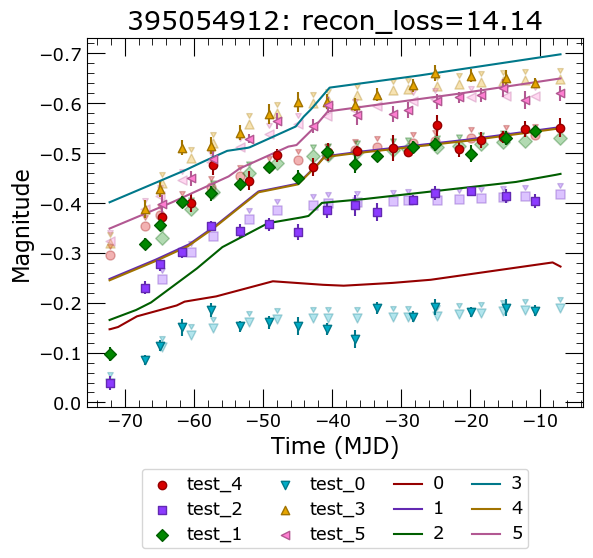

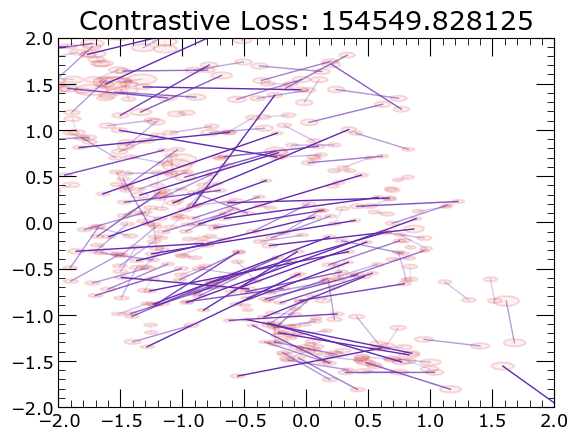

In [ ]:
# now plot decodings
from survey_agnostic_sn_vae.autoencoder.vae_plotting import plot_decodings, plot_latent_space
from survey_agnostic_sn_vae.autoencoder.raenn_equinox import VAE
import h5py
import equinox as eqx

preprocessed_fn = 'preprocessed_augmented.h5'
model_fn = '/Users/kdesoto/python_repos/survey-agnostic-sn-vae/data/sweep_data/vae_2024-09-04_batch_size-128_contrastive_params-mahalonobis_1_hidden_dim-16_include_kl-True_include_reconstructive-True_learning_rate-0.0001_num_epochs-50_out_dim-4.eqx'

config = {
    "hidden_dim": 16,
    "out_dim": 4
}

with h5py.File(preprocessed_fn, "r") as f:
    ids = f['ids'][:]
    encoder_inputs = f['encoder_input'][:]
    num_samples = len(encoder_inputs)
    train_encoder_inputs = encoder_inputs[:num_samples // 10 * 9]
    val_encoder_inputs = encoder_inputs[num_samples // 10 * 9:]
    train_ids = ids[:num_samples // 10 * 9]
    val_ids = ids[num_samples // 10 * 9:]
    
# load model
model = eqx.filter_eval_shape(VAE, **config)
model = eqx.tree_deserialise_leaves(model_fn, model)

for (fig, ax) in plot_decodings(
        val_encoder_inputs, val_ids,
        model,
        count=5
    ):
    fig.show()


# plot latent space
fig, ax = plot_latent_space(train_encoder_inputs[:256], train_ids[:256], model)
fig.show()


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725509494.698834  428617 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725509494.713348  428617 service.cc:145] XLA service 0x1686f9b60 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725509494.713377  428617 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725509494.717004  428617 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725509494.717040  428617 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 4w6hlgq0
Sweep URL: https://wandb.ai/villar-time-domain/survey_agnostic_vae_test/sweeps/4w6hlgq0


wandb: Agent Starting Run: bavsnz6e with config:
wandb: 	batch_size: 128
wandb: 	contrastive_params: mahalonobis_1
wandb: 	hidden_dim: 16
wandb: 	include_kl: True
wandb: 	include_reconstructive: True
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 250
wandb: 	out_dim: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


sim_pretraining_2024-09-05


wandb: Currently logged in as: kdesoto (villar-time-domain). Use `wandb login --relogin` to force relogin


contrastive_log_loss,▇▇▅▄▂▆▆▃▅▅▂▆█▅▇▁▇█▂▄▇▁▃▄▆▇▅▆▁▆▃▄▁▃▅▅▆▇▆▅
kl_log_loss,█▅▄▂▃▂▁▁▄▄▃▃▄▃▄▃▄▄▅▅▅▆▅▄▄▄▅▄▄▅▄▄▆▅▆▅▅▆▅▆
log_loss,▅▅▃▅▂▆▃▃▅▆▁▃▃▆▄▄▆▄▃▂▅▄▄▁▂▅▃▅▃▁▂▂▂▃▅▄█▂▄▃
reconstruction_log_loss,▄▅▃▆▃▆▄▃▆▆▂▃▃▇▄▄▆▄▃▂▄▄▄▁▂▅▃▅▄▁▂▂▂▃▅▄█▂▃▃
val_contrastive_log_loss,█▇▄▃▄▅▄▃▄▅▄▅▆▃▅▃▄▂▄▄▅▄▃▂▃▃▃▂▂▂▂▁▂▃▂▃▂▂▁▂
val_kl_log_loss,█▅▃▂▃▂▁▁▄▄▃▃▄▃▄▃▄▄▅▅▅▆▅▄▄▄▅▄▄▅▄▄▆▅▆▅▅▅▅▆
val_log_loss,▄▆▅█▇██▆▅▆▄▅▇▆▅▄▅▃▅▃▄▅▆▂▃▅▃▄▂▄▄▂▁▂▂▃▁▁▁▃
val_reconstruction_log_loss,▃▅▅█▇██▇▅▆▄▅▇▆▅▅▄▃▄▃▄▄▅▃▃▅▃▄▃▄▅▂▁▂▂▃▂▂▁▃
best_epoch,248
best_val_loss,1.17578
contrastive_log_loss,-0.27798


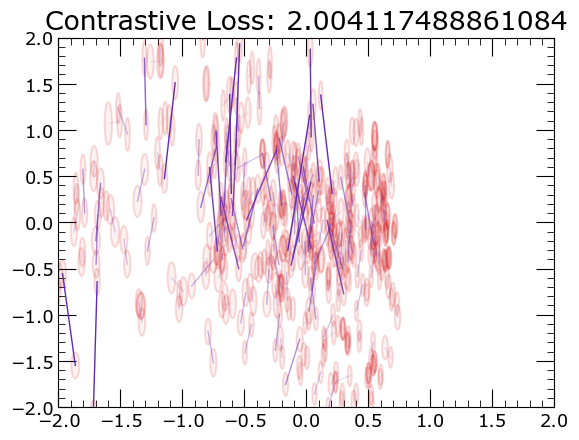

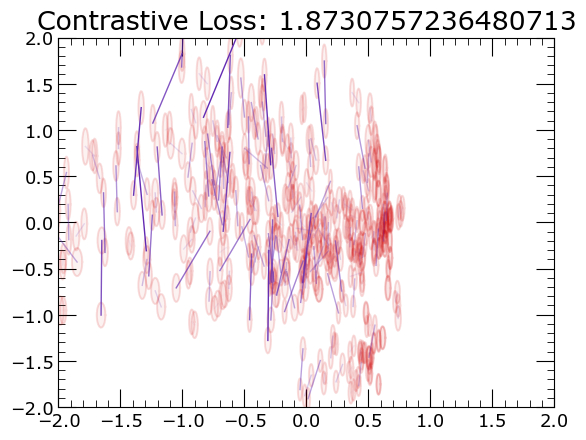

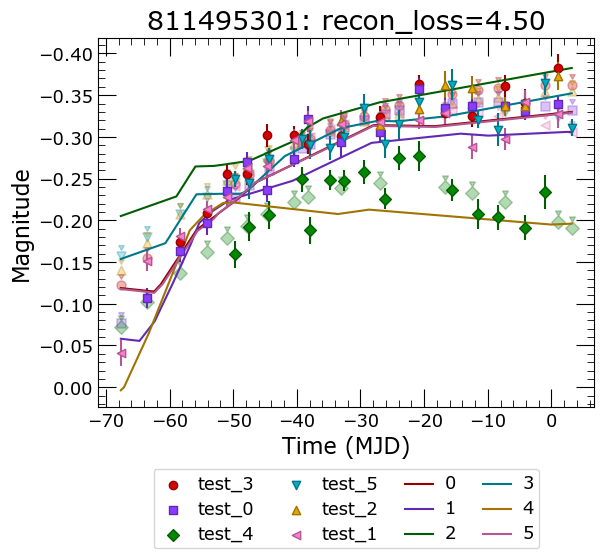

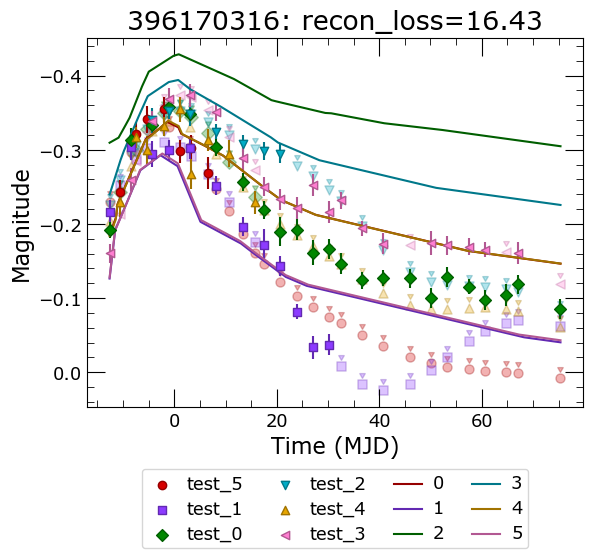

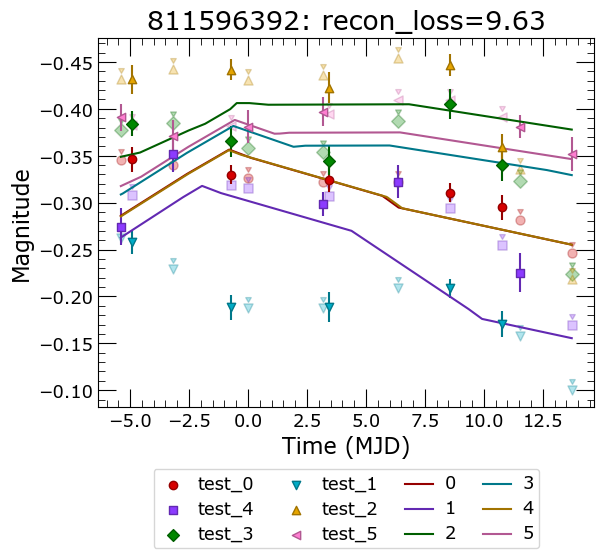

In [1]:
# WANDB SWEEP
from survey_agnostic_sn_vae.autoencoder.wandb_sweeps import *

default_config = import_config_yaml("full_wandb_config.yaml")
static_values = {
    'hidden_dim': 16,
    'out_dim': 4,
    'include_kl': True,
    'include_reconstructive': True,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'num_epochs': 250,
    'contrastive_params': 'mahalonobis_1'
}
new_config = set_config_params(default_config, static_values)
wandb_sweep(new_config, "preprocessed_augmented.h5", "sweep_data",
            checkpoint_model_fn='sweep_data/vae_2024-09-04.eqx',
            sweep_name="sim_pretraining",
            num_runs=1)

# Apply model to YSE + ZTF light curves

In [ ]:
# Import data from both YSE and ZTF
# first do ZTF
import os
from survey_agnostic_sn_vae.data_imports.import_ztf import generate_ztf_transients

SAVE_DIR = 'snapi_transients'
os.makedirs(SAVE_DIR, exist_ok=True)
generate_ztf_transients(SAVE_DIR)

STARTS
Processed 0 of 16167 objects.
Processed 1000 of 16167 objects.
Processed 2000 of 16167 objects.
Processed 3000 of 16167 objects.
Processed 4000 of 16167 objects.
Processed 5000 of 16167 objects.
Processed 6000 of 16167 objects.
Processed 7000 of 16167 objects.
Processed 8000 of 16167 objects.
Processed 9000 of 16167 objects.
Processed 10000 of 16167 objects.
Processed 11000 of 16167 objects.
Processed 12000 of 16167 objects.
Processed 13000 of 16167 objects.
Processed 14000 of 16167 objects.
Processed 15000 of 16167 objects.
Processed 16000 of 16167 objects.


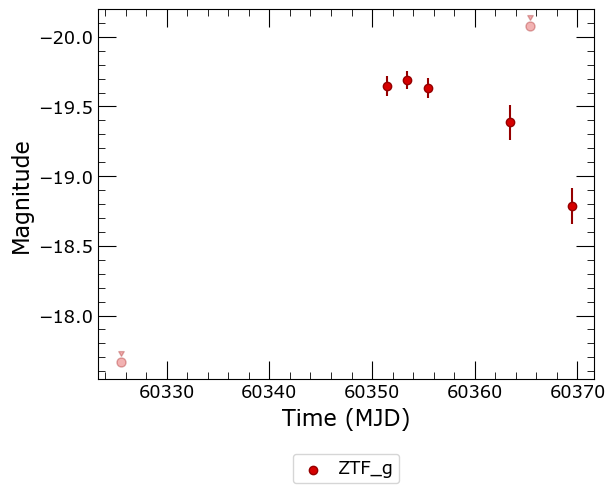

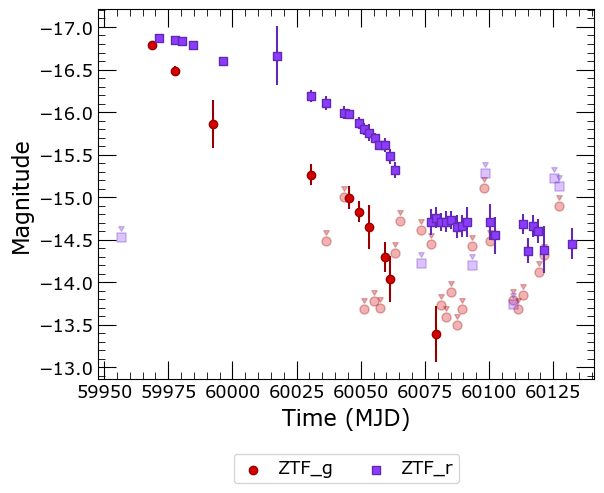

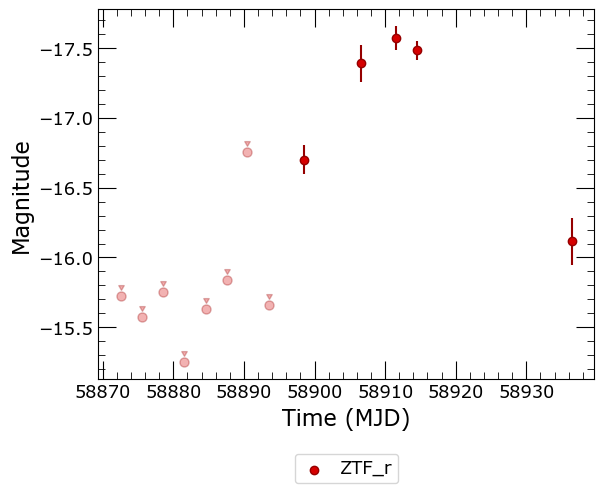

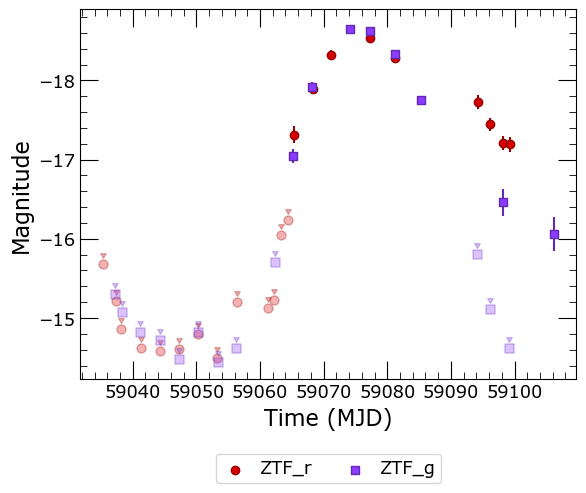

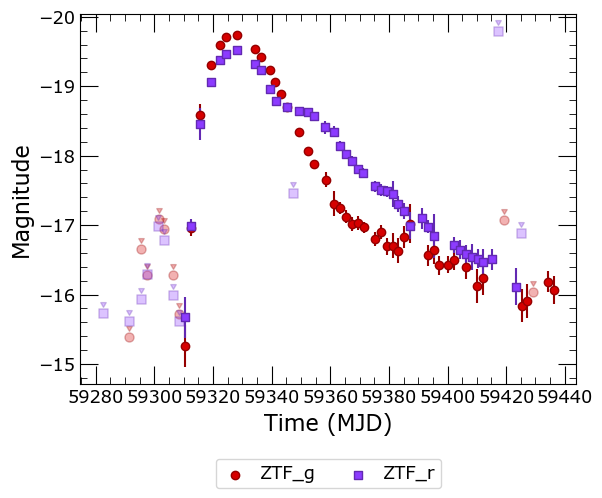

0


In [ ]:
# plot some ZTF LCs
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

formatter = Formatter()
for fn in glob.glob("snapi_transients/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()


In [ ]:
# copy folder to separate folder for modification
import shutil, os

if os.path.exists("snapi_transients_combined"):
    shutil.rmtree("snapi_transients_combined")
shutil.copytree("snapi_transients", "snapi_transients_combined", )

'snapi_transients_combined'

In [ ]:
# add YSE data
from survey_agnostic_sn_vae.data_imports.import_yse_dr1 import generate_yse_transients

generate_yse_transients(
    'yse_dr1_zenodo_snr_geq_4',
    'snapi_transients_combined'
)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


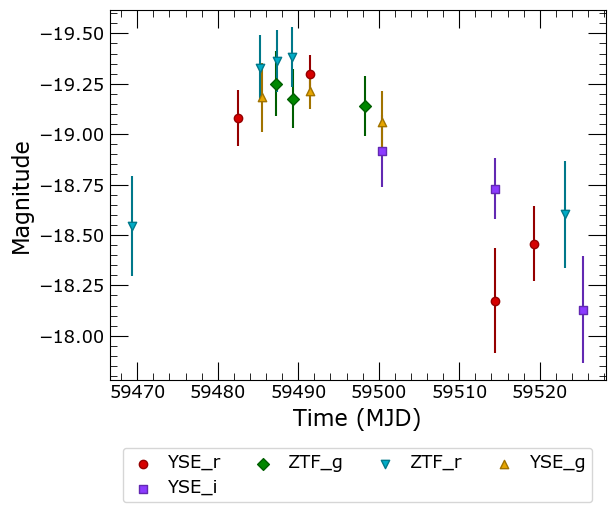

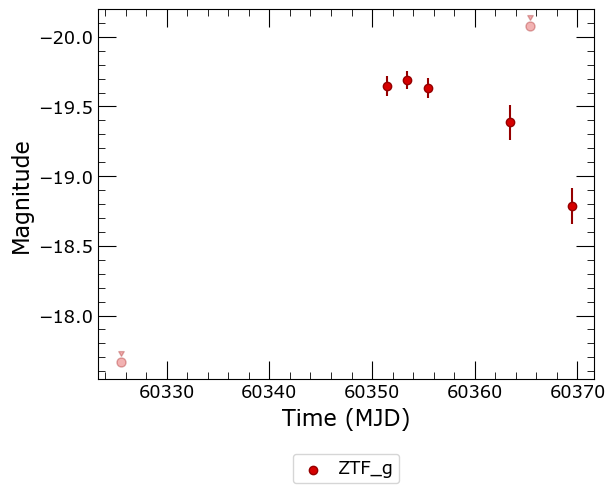

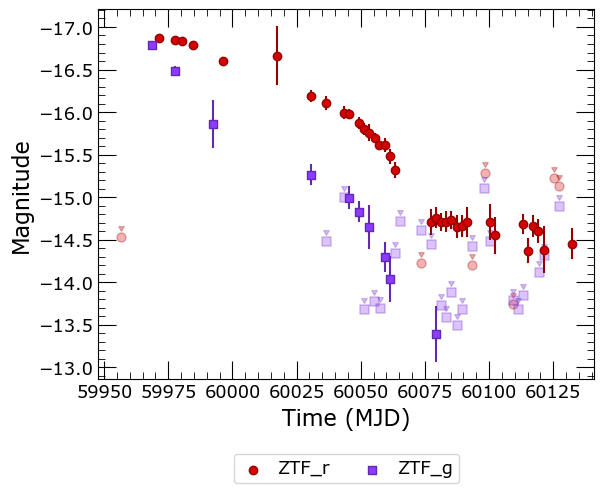

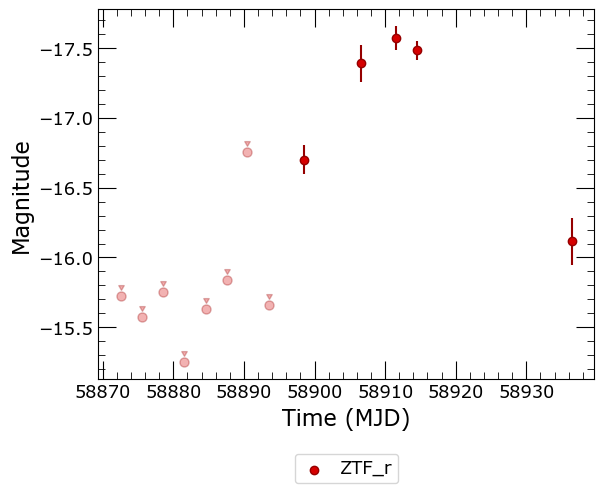

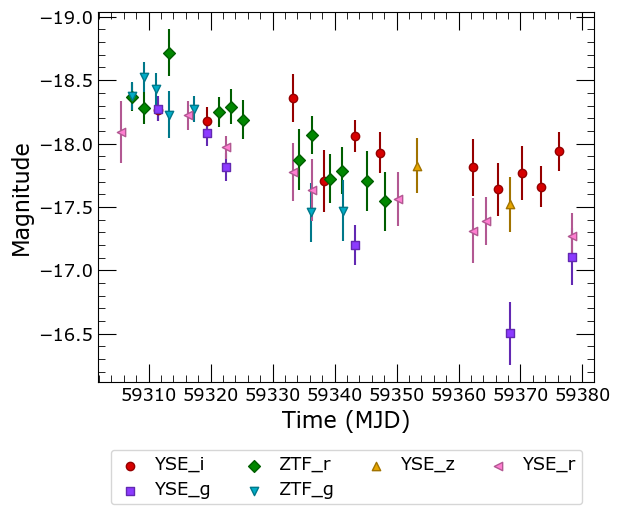

2


In [ ]:
# plot combined LC
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

num_without_coords = 0
formatter = Formatter()
for fn in glob.glob("snapi_transients_combined/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    if transient.coordinates is None:
        num_without_coords += 1
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

print(num_without_coords)



In [1]:
# now create full preprocessed file - save to HDF5
import warnings

warnings.filterwarnings("ignore")

from survey_agnostic_sn_vae.preprocessing import prep_input

dense_arr, meta_dict = prep_input(
    "snapi_transients_combined",
    save=True,
    save_fn='preprocessed_real.h5'
)


Pre-processed 0 out of 10667 transients...
Pre-processed 50 out of 10667 transients...
Pre-processed 100 out of 10667 transients...
Pre-processed 150 out of 10667 transients...
Pre-processed 200 out of 10667 transients...
Pre-processed 250 out of 10667 transients...
Pre-processed 300 out of 10667 transients...
Pre-processed 350 out of 10667 transients...
Pre-processed 400 out of 10667 transients...
Pre-processed 450 out of 10667 transients...
Pre-processed 500 out of 10667 transients...
Pre-processed 550 out of 10667 transients...
Pre-processed 600 out of 10667 transients...
Pre-processed 650 out of 10667 transients...
Pre-processed 700 out of 10667 transients...
Pre-processed 750 out of 10667 transients...
Pre-processed 800 out of 10667 transients...
Pre-processed 850 out of 10667 transients...
Pre-processed 900 out of 10667 transients...
Pre-processed 950 out of 10667 transients...
Pre-processed 1000 out of 10667 transients...
Pre-processed 1050 out of 10667 transients...
Pre-process

In [1]:
# WANDB RUN
from survey_agnostic_sn_vae.autoencoder.wandb_sweeps import *

default_config = import_config_yaml("full_wandb_config.yaml")
static_values = {
    'hidden_dim': 16,
    'out_dim': 4,
    'include_kl': True,
    'include_reconstructive': True,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'num_epochs': 100,
    #'contrastive_params': 'mahalonobis_1',
    'contrastive_params': None,
    'transfer_learning': False
}
new_config = set_config_params(default_config, static_values)
wandb_sweep(new_config, "preprocessed_real.h5", "sweep_data",
            #checkpoint_model_fn='sweep_data/vae_2024-09-05.eqx',
            checkpoint_model_fn='sweep_data/vaeno_contrast_learning_yse_ztf_2024-09-05.eqx',
            sweep_name="no_contrast_learning_yse_ztf",
            num_runs=1)


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725558946.050598 1503011 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725558946.064069 1503011 service.cc:145] XLA service 0x168352230 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725558946.064082 1503011 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725558946.066027 1503011 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725558946.066165 1503011 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 51qv4slv
Sweep URL: https://wandb.ai/villar-time-domain/survey_agnostic_vae_test/sweeps/51qv4slv


wandb: Agent Starting Run: xcxodg5n with config:
wandb: 	batch_size: 128
wandb: 	contrastive_params: None
wandb: 	hidden_dim: 16
wandb: 	include_kl: True
wandb: 	include_reconstructive: True
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 100
wandb: 	out_dim: 4
wandb: 	transfer_learning: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


no_contrast_learning_yse_ztf_2024-09-05


wandb: Currently logged in as: kdesoto (villar-time-domain). Use `wandb login --relogin` to force relogin


2024-09-05 13:55:56.060123: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %multiply.2168 = f32[1746,192,1]{2,1,0} multiply(f32[1746,192,1]{2,1,0} %constant.1443, f32[1746,192,1]{2,1,0} %constant.1444)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-09-05 13:55:56.250675: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.194498s
Constant folding an instruction is taking > 1s:

  %multiply.2168 = f32[1746,192,1]{2,1,0} multiply(f32[1746,192,1]{2,1,0} %constant.1443, f32[1746,192,1]{2,1,0} %constant.1444)

This isn't necessarily a bug; constant-folding

In [15]:
# make sure freezing layers worked correctly

from survey_agnostic_sn_vae.autoencoder.wandb_sweeps import *
import numpy as np

vae_config = {
    'hidden_dim': 16,
    'out_dim': 4
}

orig_model_fn = "sweep_data/vae_2024-09-05.eqx"
yse_model_fn = "sweep_data/vaetransfer_learning_yse_ztf_2024-09-05.eqx"

orig_model = eqx.filter_eval_shape(VAE, **vae_config)
orig_model = eqx.tree_deserialise_leaves(orig_model_fn, orig_model)

yse_model = eqx.filter_eval_shape(VAE, **vae_config)
yse_model = eqx.tree_deserialise_leaves(yse_model_fn, yse_model)

for l in orig_model.encoder.vmapped_layers:
    try:
        orig_layer1 = l.dense.weight
        yse_layer1 = l.dense.weight
        assert np.all(orig_layer1 == yse_layer1)
    except:
        continue

# now check latent_means layers are different
lm1 = orig_model.latent_mean.weight
lm2 = yse_model.latent_mean.weight
assert np.any(lm1 != lm2)

dec1 = orig_model.decoder.layers[0].dense.weight
dec2 = yse_model.decoder.layers[0].dense.weight
assert np.any(dec1 != dec2)


for l in orig_model.decoder.layers[1:]:
    try:
        orig_layer1 = l.dense.weight
        yse_layer1 = l.dense.weight
        assert np.all(orig_layer1 == yse_layer1)
    except:
        continue

In [ ]:
# run classification on all Pan-STARRS samples
from survey_agnostic_sn_vae.classification import *
from superphot_plus.plotting.format_params import set_global_plot_formatting

set_global_plot_formatting()

OUTFILE = 'superraenn/yse/outputs/out.npz'
feats, feat_errs, y = get_data(
    OUTFILE,
    include_surveys=['YSE', 'joint', 'ZTF'],
    data_type='3way'
)
for t in np.unique(y):
    plt.scatter(feats[:,0][y == t], feats[:,1][y == t], s=2)
plt.show()

for t in np.unique(y):
    plt.scatter(feats[:,1][y == t], feats[:,2][y == t], s=2)
plt.show()

vanilla_rf(feats, feat_errs, y)
#vanilla_mlp(feats, feat_errs, y)

NameError: name 'survey_submask' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
# compare inter-modal and cross-modal reconstructions for each metric
import torch
import os
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.archival.raenn import SNDataset
from survey_agnostic_sn_vae.metrics import *
LCFILE = 'superraenn/lcs.npz'
OUTDIR = 'superraenn'
PREPFILE = 'superraenn/prep.npz'

sequence, outseq, loss_mask, meta_dict = prep_input(
    LCFILE, load=True, outdir=OUTDIR, prep_file=PREPFILE
)
device = 'cpu'
seq_ids = sequence[:,0,-1]
sequence = sequence[:,:,:-1]

(
    train_seq, test_seq,
    train_out, test_out,
    train_id, test_id,
    train_mask, test_mask
) = train_test_split(
    sequence, outseq,
    seq_ids, loss_mask,
    shuffle=False,
    test_size=0.2
)

dataset = SNDataset(test_seq, test_out, test_id, test_mask, device=device)
train_dataset = SNDataset(train_seq, train_out, train_id, train_mask, device=device)

device='cpu'
for metric in [
    'cosine_means', 'cosine', 'euclidean', 'euclidean_means',
    'mahalonobis', 'wasserstein'
]:
    model_fn = os.path.join(OUTDIR, f"contrastive_{metric}/model_2024-05-29_2_100.pt")
    model = torch.load(model_fn).to(device)
    print(metric)
    print(calc_cross_modal_weighted_mse(model, dataset))
    print(calc_inter_modal_weighted_mse(model, dataset))
    print(calc_cross_modal_weighted_mse(model, train_dataset))
    print(calc_inter_modal_weighted_mse(model, train_dataset))

cosine_means
22.27439308166504
19.535646438598633
23.43224334716797
17.67462158203125
cosine
25.417800903320312
20.026538848876953
25.010828018188477
17.99529457092285
euclidean
20.7857723236084
20.65812110900879
18.952260971069336
17.858882904052734
euclidean_means
19.41083335876465
20.83446502685547
19.101354598999023
18.192901611328125
mahalonobis
20.164215087890625
17.738910675048828
17.4075984954834
16.672931671142578
wasserstein
20.497554779052734
19.242748260498047
19.344745635986328
16.892650604248047
